# Run this code twice after the stage0 and stage0

In [17]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]='0'

import warnings
warnings.filterwarnings("ignore")

import sys
sys.path.append('waveglow/')

import matplotlib.pyplot as plt
%matplotlib inline

import IPython.display as ipd
import pickle as pkl
import torch
import torch.nn.functional as F
import hparams
from torch.utils.data import DataLoader
from modules.model import Model
from text import text_to_sequence, sequence_to_text
from denoiser import Denoiser
from tqdm import tqdm_notebook as tqdm
import librosa
from modules.loss import MDNLoss
import math
from multiprocessing import Pool
import numpy as np

data_type = 'char'
checkpoint_path = f"training_log/aligntts/stage0/checkpoint_40000"

from glob import glob

# checkpoint_path = sorted(glob("training_log/aligntts/stage0/checkpoint_*"))[-1]

print(checkpoint_path)


state_dict = {}
for k, v in torch.load(checkpoint_path)['state_dict'].items():
    state_dict[k[7:]]=v


model = Model(hparams).cuda()
model.load_state_dict(state_dict)
_ = model.cuda().eval()
criterion = MDNLoss()

training_log/aligntts/stage0/checkpoint_40000


In [18]:
import time

In [19]:
datasets = ['train', 'val', 'test']
batch_size=64
batch_size = 16

start = time.perf_counter()

for dataset in datasets:
    
    with open(f'filelists/ljs_audio_text_{dataset}_filelist.txt', 'r') as f:
        lines_raw = [line.split('|') for line in f.read().splitlines()]
        lines_list = [ lines_raw[batch_size*i:batch_size*(i+1)] 
                      for i in range(len(lines_raw)//batch_size+1)]
        
    for num, batch in tqdm(enumerate(lines_list)):
        
        single_loop_start = time.perf_counter()
        
        file_list, text_list, mel_list = [], [], []
        text_lengths, mel_lengths=[], []
        
        for i in range(len(batch)):
            file_name, _, text = batch[i]
            file_list.append(file_name)
            seq_path = os.path.join('../Dataset/LJSpeech-1.1/preprocessed',
                               f'{data_type}_seq')
            mel_path = os.path.join('../Dataset/LJSpeech-1.1/preprocessed',
                               'melspectrogram')
            try:
                seq = torch.from_numpy(np.load(f'{seq_path}/{file_name}_sequence.npy'))
            except FileNotFoundError:
                with open(f'{seq_path}/{file_name}_sequence.pkl', 'rb') as f:
                    seq = pkl.load(f)
            
            try:
                mel = torch.from_numpy(np.load(f'{mel_path}/{file_name}_melspectrogram.npy'))
            except FileNotFoundError:
                with open(f'{mel_path}/{file_name}_melspectrogram.pkl', 'rb') as f:
                    mel = pkl.load(f)
            
            text_list.append(seq)
            mel_list.append(mel)
            text_lengths.append(seq.size(0))
            mel_lengths.append(mel.size(1))
            
        io_time = time.perf_counter()
            
        text_lengths = torch.LongTensor(text_lengths)
        mel_lengths = torch.LongTensor(mel_lengths)
        text_padded = torch.zeros(len(batch), text_lengths.max().item(), dtype=torch.long)
        mel_padded = torch.zeros(len(batch), hparams.n_mel_channels, mel_lengths.max().item())
        
        for j in range(len(batch)):
            text_padded[j, :text_list[j].size(0)] = text_list[j]
            mel_padded[j, :, :mel_list[j].size(1)] = mel_list[j]
        
        text_padded = text_padded.cuda()
        mel_padded = mel_padded.cuda()
        text_lengths = text_lengths.cuda()
        mel_lengths = mel_lengths.cuda()
        
        with torch.no_grad():
            
            model_start = time.perf_counter()
            
            encoder_input = model.Prenet(text_padded)
            hidden_states, _ = model.FFT_lower(encoder_input, text_lengths)
            mu_sigma = model.get_mu_sigma(hidden_states)
            _, log_prob_matrix = criterion(mu_sigma, mel_padded, text_lengths, mel_lengths)
            
            viterbi_start = time.perf_counter()

            align = model.viterbi(log_prob_matrix, text_lengths, mel_lengths).to(torch.long)
            alignments = list(torch.split(align,1))
            
            viterbi_end = time.perf_counter()
        
        print('VT Time: ', end=' ')
        print(f'{viterbi_end - viterbi_start:.6f} / {viterbi_end - single_loop_start:.6f} = ' +
             f'{(viterbi_end - viterbi_start) / (viterbi_end - single_loop_start) * 100:5.2f}%')
        
        print('IO Time: ', end=' ')
        print(f'{io_time - single_loop_start:.6f} / {viterbi_end - single_loop_start:.6f} = ' +
             f'{(io_time - single_loop_start) / (viterbi_end - single_loop_start) * 100:5.2f}%')
        
        print('DL Time: ', end=' ')
        print(f'{viterbi_start - model_start:.6f} / {viterbi_end - single_loop_start:.6f} = ' +
             f'{(viterbi_start - model_start) / (viterbi_end - single_loop_start) * 100:5.2f}%')
        
#         print(alignments[0].shape)

        print()
        
        if num >= 5:
            break
       
#         for j, (l, t) in enumerate(zip(text_lengths, mel_lengths)):
#             alignments[j] = alignments[j][0, :l.item(), :t.item()].sum(dim=-1)
#             np.save(f'../Dataset/LJSpeech-1.1/preprocessed/alignments/{file_list[j]}_alignment.npy',
#                     alignments[j].detach().cpu().numpy())

VT Time:  0.486503 / 0.786500 = 61.86%
IO Time:  0.004842 / 0.786500 =  0.62%
DL Time:  0.291032 / 0.786500 = 37.00%

VT Time:  0.475425 / 0.707545 = 67.19%
IO Time:  0.004928 / 0.707545 =  0.70%
DL Time:  0.222359 / 0.707545 = 31.43%

VT Time:  0.434073 / 0.740829 = 58.59%
IO Time:  0.005643 / 0.740829 =  0.76%
DL Time:  0.293523 / 0.740829 = 39.62%

VT Time:  0.307858 / 0.558429 = 55.13%
IO Time:  0.004869 / 0.558429 =  0.87%
DL Time:  0.239289 / 0.558429 = 42.85%

VT Time:  0.373690 / 0.542530 = 68.88%
IO Time:  0.003370 / 0.542530 =  0.62%
DL Time:  0.163468 / 0.542530 = 30.13%

VT Time:  0.267517 / 0.417813 = 64.03%
IO Time:  0.003359 / 0.417813 =  0.80%
DL Time:  0.145239 / 0.417813 = 34.76%




VT Time:  0.246965 / 0.384785 = 64.18%
IO Time:  0.003117 / 0.384785 =  0.81%
DL Time:  0.133025 / 0.384785 = 34.57%

VT Time:  0.256890 / 0.393638 = 65.26%
IO Time:  0.003002 / 0.393638 =  0.76%
DL Time:  0.132240 / 0.393638 = 33.59%

VT Time:  0.294537 / 0.483674 = 60.90%
IO Time:  0.003151 / 0.483674 =  0.65%
DL Time:  0.183980 / 0.483674 = 38.04%

VT Time:  0.299999 / 0.478861 = 62.65%
IO Time:  0.003039 / 0.478861 =  0.63%
DL Time:  0.173794 / 0.478861 = 36.29%

VT Time:  0.280290 / 0.452298 = 61.97%
IO Time:  0.003078 / 0.452298 =  0.68%
DL Time:  0.167126 / 0.452298 = 36.95%

VT Time:  0.284778 / 0.476170 = 59.81%
IO Time:  0.003243 / 0.476170 =  0.68%
DL Time:  0.186168 / 0.476170 = 39.10%




VT Time:  0.295862 / 0.459032 = 64.45%
IO Time:  0.003027 / 0.459032 =  0.66%
DL Time:  0.158504 / 0.459032 = 34.53%

VT Time:  0.285892 / 0.488490 = 58.53%
IO Time:  0.003241 / 0.488490 =  0.66%
DL Time:  0.197453 / 0.488490 = 40.42%

VT Time:  0.290224 / 0.468928 = 61.89%
IO Time:  0.003112 / 0.468928 =  0.66%
DL Time:  0.173814 / 0.468928 = 37.07%

VT Time:  0.313699 / 0.496846 = 63.14%
IO Time:  0.003420 / 0.496846 =  0.69%
DL Time:  0.177783 / 0.496846 = 35.78%

VT Time:  0.316794 / 0.509048 = 62.23%
IO Time:  0.003397 / 0.509048 =  0.67%
DL Time:  0.187003 / 0.509048 = 36.74%

VT Time:  0.322222 / 0.498112 = 64.69%
IO Time:  0.003182 / 0.498112 =  0.64%
DL Time:  0.170791 / 0.498112 = 34.29%




In [20]:
datasets = ['train', 'val', 'test']
batch_size=64
batch_size = 16

start = time.perf_counter()

for dataset in datasets:
    
    with open(f'filelists/ljs_audio_text_{dataset}_filelist.txt', 'r') as f:
        lines_raw = [line.split('|') for line in f.read().splitlines()]
        lines_list = [ lines_raw[batch_size*i:batch_size*(i+1)] 
                      for i in range(len(lines_raw)//batch_size+1)]
        
    for num, batch in tqdm(enumerate(lines_list)):
        
        single_loop_start = time.perf_counter()
        
        file_list, text_list, mel_list = [], [], []
        text_lengths, mel_lengths=[], []
        
        for i in range(len(batch)):
            file_name, _, text = batch[i]
            file_list.append(file_name)
            seq_path = os.path.join('../Dataset/LJSpeech-1.1/preprocessed',
                               f'{data_type}_seq')
            mel_path = os.path.join('../Dataset/LJSpeech-1.1/preprocessed',
                               'melspectrogram')
            try:
                seq = torch.from_numpy(np.load(f'{seq_path}/{file_name}_sequence.npy'))
            except FileNotFoundError:
                with open(f'{seq_path}/{file_name}_sequence.pkl', 'rb') as f:
                    seq = pkl.load(f)
            
            try:
                mel = torch.from_numpy(np.load(f'{mel_path}/{file_name}_melspectrogram.npy'))
            except FileNotFoundError:
                with open(f'{mel_path}/{file_name}_melspectrogram.pkl', 'rb') as f:
                    mel = pkl.load(f)
            
            text_list.append(seq)
            mel_list.append(mel)
            text_lengths.append(seq.size(0))
            mel_lengths.append(mel.size(1))
            
        io_time = time.perf_counter()
            
        text_lengths = torch.LongTensor(text_lengths)
        mel_lengths = torch.LongTensor(mel_lengths)
        text_padded = torch.zeros(len(batch), text_lengths.max().item(), dtype=torch.long)
        mel_padded = torch.zeros(len(batch), hparams.n_mel_channels, mel_lengths.max().item())
        
        for j in range(len(batch)):
            text_padded[j, :text_list[j].size(0)] = text_list[j]
            mel_padded[j, :, :mel_list[j].size(1)] = mel_list[j]
        
        text_padded = text_padded.cuda()
        mel_padded = mel_padded.cuda()
        text_lengths = text_lengths.cuda()
        mel_lengths = mel_lengths.cuda()
        
        with torch.no_grad():
            
            model_start = time.perf_counter()
            
            encoder_input = model.Prenet(text_padded)
            hidden_states, _ = model.FFT_lower(encoder_input, text_lengths)
            mu_sigma = model.get_mu_sigma(hidden_states)
            _, log_prob_matrix = criterion(mu_sigma, mel_padded, text_lengths, mel_lengths)
            
            viterbi_start = time.perf_counter()

            align = model.viterbi_cpu(log_prob_matrix, text_lengths.cpu(), mel_lengths.cpu()).to(torch.long)
            alignments = list(torch.split(align,1))
            
            viterbi_end = time.perf_counter()
        
        print('VT Time: ', end=' ')
        print(f'{viterbi_end - viterbi_start:.6f} / {viterbi_end - single_loop_start:.6f} = ' +
             f'{(viterbi_end - viterbi_start) / (viterbi_end - single_loop_start) * 100:5.2f}%')
        
        print('IO Time: ', end=' ')
        print(f'{io_time - single_loop_start:.6f} / {viterbi_end - single_loop_start:.6f} = ' +
             f'{(io_time - single_loop_start) / (viterbi_end - single_loop_start) * 100:5.2f}%')
        
        print('DL Time: ', end=' ')
        print(f'{viterbi_start - model_start:.6f} / {viterbi_end - single_loop_start:.6f} = ' +
             f'{(viterbi_start - model_start) / (viterbi_end - single_loop_start) * 100:5.2f}%')
        
#         print(alignments[0].shape)

        print()
        
        if num >= 5:
            break
       
#         for j, (l, t) in enumerate(zip(text_lengths, mel_lengths)):
#             alignments[j] = alignments[j][0, :l.item(), :t.item()].sum(dim=-1)
#             np.save(f'../Dataset/LJSpeech-1.1/preprocessed/alignments/{file_list[j]}_alignment.npy',
#                     alignments[j].detach().cpu().numpy())

VT Time:  0.152491 / 0.351124 = 43.43%
IO Time:  0.004881 / 0.351124 =  1.39%
DL Time:  0.191694 / 0.351124 = 54.59%

VT Time:  0.140085 / 0.319928 = 43.79%
IO Time:  0.003766 / 0.319928 =  1.18%
DL Time:  0.174198 / 0.319928 = 54.45%

VT Time:  0.201152 / 0.383323 = 52.48%
IO Time:  0.003156 / 0.383323 =  0.82%
DL Time:  0.176623 / 0.383323 = 46.08%

VT Time:  0.144697 / 0.325955 = 44.39%
IO Time:  0.003316 / 0.325955 =  1.02%
DL Time:  0.175389 / 0.325955 = 53.81%

VT Time:  0.141139 / 0.321545 = 43.89%
IO Time:  0.003233 / 0.321545 =  1.01%
DL Time:  0.175413 / 0.321545 = 54.55%

VT Time:  0.163187 / 0.332206 = 49.12%
IO Time:  0.003260 / 0.332206 =  0.98%
DL Time:  0.163944 / 0.332206 = 49.35%




VT Time:  0.212011 / 0.424983 = 49.89%
IO Time:  0.003214 / 0.424983 =  0.76%
DL Time:  0.200228 / 0.424983 = 47.11%

VT Time:  0.164125 / 0.368553 = 44.53%
IO Time:  0.003056 / 0.368553 =  0.83%
DL Time:  0.198048 / 0.368553 = 53.74%

VT Time:  0.347008 / 0.603943 = 57.46%
IO Time:  0.009084 / 0.603943 =  1.50%
DL Time:  0.245851 / 0.603943 = 40.71%

VT Time:  0.300127 / 0.535661 = 56.03%
IO Time:  0.004643 / 0.535661 =  0.87%
DL Time:  0.225264 / 0.535661 = 42.05%

VT Time:  0.296904 / 0.551160 = 53.87%
IO Time:  0.004843 / 0.551160 =  0.88%
DL Time:  0.247653 / 0.551160 = 44.93%

VT Time:  0.257527 / 0.519989 = 49.53%
IO Time:  0.007526 / 0.519989 =  1.45%
DL Time:  0.249244 / 0.519989 = 47.93%




VT Time:  0.303565 / 0.578213 = 52.50%
IO Time:  0.003285 / 0.578213 =  0.57%
DL Time:  0.269647 / 0.578213 = 46.63%

VT Time:  0.216774 / 0.420632 = 51.54%
IO Time:  0.005170 / 0.420632 =  1.23%
DL Time:  0.194095 / 0.420632 = 46.14%

VT Time:  0.274816 / 0.562742 = 48.84%
IO Time:  0.003421 / 0.562742 =  0.61%
DL Time:  0.282802 / 0.562742 = 50.25%

VT Time:  0.299667 / 0.600331 = 49.92%
IO Time:  0.006365 / 0.600331 =  1.06%
DL Time:  0.292344 / 0.600331 = 48.70%

VT Time:  0.215408 / 0.464216 = 46.40%
IO Time:  0.004366 / 0.464216 =  0.94%
DL Time:  0.242438 / 0.464216 = 52.23%

VT Time:  0.127434 / 0.345074 = 36.93%
IO Time:  0.004589 / 0.345074 =  1.33%
DL Time:  0.210919 / 0.345074 = 61.12%




In [27]:
datasets = ['train', 'val', 'test']
batch_size=64
batch_size = 16

start = time.perf_counter()

for dataset in datasets:
    
    with open(f'filelists/ljs_audio_text_{dataset}_filelist.txt', 'r') as f:
        lines_raw = [line.split('|') for line in f.read().splitlines()]
        lines_list = [ lines_raw[batch_size*i:batch_size*(i+1)] 
                      for i in range(len(lines_raw)//batch_size+1)]
        
    for num, batch in tqdm(enumerate(lines_list)):
        
        single_loop_start = time.perf_counter()
        
        file_list, text_list, mel_list = [], [], []
        text_lengths, mel_lengths=[], []
        
        for i in range(len(batch)):
            file_name, _, text = batch[i]
            file_list.append(file_name)
            seq_path = os.path.join('../Dataset/LJSpeech-1.1/preprocessed',
                               f'{data_type}_seq')
            mel_path = os.path.join('../Dataset/LJSpeech-1.1/preprocessed',
                               'melspectrogram')
            try:
                seq = torch.from_numpy(np.load(f'{seq_path}/{file_name}_sequence.npy'))
            except FileNotFoundError:
                with open(f'{seq_path}/{file_name}_sequence.pkl', 'rb') as f:
                    seq = pkl.load(f)
            
            try:
                mel = torch.from_numpy(np.load(f'{mel_path}/{file_name}_melspectrogram.npy'))
            except FileNotFoundError:
                with open(f'{mel_path}/{file_name}_melspectrogram.pkl', 'rb') as f:
                    mel = pkl.load(f)
            
            text_list.append(seq)
            mel_list.append(mel)
            text_lengths.append(seq.size(0))
            mel_lengths.append(mel.size(1))
            
        io_time = time.perf_counter()
            
        text_lengths = torch.LongTensor(text_lengths)
        mel_lengths = torch.LongTensor(mel_lengths)
        text_padded = torch.zeros(len(batch), text_lengths.max().item(), dtype=torch.long)
        mel_padded = torch.zeros(len(batch), hparams.n_mel_channels, mel_lengths.max().item())
        
        for j in range(len(batch)):
            text_padded[j, :text_list[j].size(0)] = text_list[j]
            mel_padded[j, :, :mel_list[j].size(1)] = mel_list[j]
        
        text_padded = text_padded.cuda()
        mel_padded = mel_padded.cuda()
        text_lengths = text_lengths.cuda()
        mel_lengths = mel_lengths.cuda()
        
        with torch.no_grad():
            
            model_start = time.perf_counter()
            
            encoder_input = model.Prenet(text_padded)
            hidden_states, _ = model.FFT_lower(encoder_input, text_lengths)
            mu_sigma = model.get_mu_sigma(hidden_states)
            _, log_prob_matrix = criterion(mu_sigma, mel_padded, text_lengths, mel_lengths)
            
            viterbi_start = time.perf_counter()

#             align_ = model.fast_viterbi(log_prob_matrix, text_lengths, mel_lengths).to(log_prob_matrix.device)
#             alignments_ = list(torch.split(align_,1))
            align_ = model.viterbi_cpu(log_prob_matrix, text_lengths.cpu(), mel_lengths.cpu())
            alignments_ = list(torch.split(align_,1))
            
            viterbi_end = time.perf_counter()
            
            viterbi_origin_start = time.perf_counter()

            align = model.viterbi(log_prob_matrix, text_lengths, mel_lengths).to(torch.long)
            alignments = list(torch.split(align,1))
            
            viterbi_origin_end = time.perf_counter()
            
#         print(alignments_ == alignments)
        
        print('VT_ Time: ', end=' ')
        print(f'{viterbi_origin_end - viterbi_origin_start:.6f}')
              
        print('VTF Time: ', end=' ')
        print(f'{viterbi_end - viterbi_start:.6f} / {viterbi_end - single_loop_start:.6f} = ' +
             f'{(viterbi_end - viterbi_start) / (viterbi_end - single_loop_start) * 100:5.2f}%')
       
    
        print('IO_ Time: ', end=' ')
        print(f'{io_time - single_loop_start:.6f} / {viterbi_end - single_loop_start:.6f} = ' +
             f'{(io_time - single_loop_start) / (viterbi_end - single_loop_start) * 100:5.2f}%')
        
        print('DL_ Time: ', end=' ')
        print(f'{viterbi_start - model_start:.6f} / {viterbi_end - single_loop_start:.6f} = ' +
             f'{(viterbi_start - model_start) / (viterbi_end - single_loop_start) * 100:5.2f}%')
        
        print()
        
        
        
        if num >= 5:
            break
       
#         for j, (l, t) in enumerate(zip(text_lengths, mel_lengths)):
#             alignments[j] = alignments[j][0, :l.item(), :t.item()].sum(dim=-1)
#             np.save(f'../Dataset/LJSpeech-1.1/preprocessed/alignments/{file_list[j]}_alignment.npy',
#                     alignments[j].detach().cpu().numpy())

VT_ Time:  0.400385
VTF Time:  0.231643 / 0.458897 = 50.48%
IO_ Time:  0.005225 / 0.458897 =  1.14%
DL_ Time:  0.213661 / 0.458897 = 46.56%

VT_ Time:  0.451082
VTF Time:  0.314608 / 0.547268 = 57.49%
IO_ Time:  0.005696 / 0.547268 =  1.04%
DL_ Time:  0.224933 / 0.547268 = 41.10%

VT_ Time:  0.496008
VTF Time:  0.261830 / 0.556449 = 47.05%
IO_ Time:  0.010246 / 0.556449 =  1.84%
DL_ Time:  0.282315 / 0.556449 = 50.74%

VT_ Time:  0.540181
VTF Time:  0.246626 / 0.446843 = 55.19%
IO_ Time:  0.008264 / 0.446843 =  1.85%
DL_ Time:  0.190084 / 0.446843 = 42.54%

VT_ Time:  0.329698
VTF Time:  0.150063 / 0.443889 = 33.81%
IO_ Time:  0.005283 / 0.443889 =  1.19%
DL_ Time:  0.284028 / 0.443889 = 63.99%

VT_ Time:  0.481985
VTF Time:  0.173582 / 0.328670 = 52.81%
IO_ Time:  0.003396 / 0.328670 =  1.03%
DL_ Time:  0.150070 / 0.328670 = 45.66%




VT_ Time:  0.380365
VTF Time:  0.146097 / 0.500832 = 29.17%
IO_ Time:  0.004429 / 0.500832 =  0.88%
DL_ Time:  0.340159 / 0.500832 = 67.92%

VT_ Time:  0.386520
VTF Time:  0.316907 / 0.609288 = 52.01%
IO_ Time:  0.004943 / 0.609288 =  0.81%
DL_ Time:  0.280727 / 0.609288 = 46.07%

VT_ Time:  0.517519
VTF Time:  0.286946 / 0.554350 = 51.76%
IO_ Time:  0.006563 / 0.554350 =  1.18%
DL_ Time:  0.255564 / 0.554350 = 46.10%

VT_ Time:  0.497233
VTF Time:  0.300808 / 0.600893 = 50.06%
IO_ Time:  0.003936 / 0.600893 =  0.66%
DL_ Time:  0.286254 / 0.600893 = 47.64%

VT_ Time:  0.875657
VTF Time:  0.261594 / 0.509388 = 51.35%
IO_ Time:  0.004382 / 0.509388 =  0.86%
DL_ Time:  0.233244 / 0.509388 = 45.79%

VT_ Time:  0.759679
VTF Time:  0.309536 / 0.556519 = 55.62%
IO_ Time:  0.005051 / 0.556519 =  0.91%
DL_ Time:  0.237672 / 0.556519 = 42.71%




VT_ Time:  0.555144
VTF Time:  0.205186 / 0.402470 = 50.98%
IO_ Time:  0.003361 / 0.402470 =  0.84%
DL_ Time:  0.190745 / 0.402470 = 47.39%

VT_ Time:  0.678756
VTF Time:  0.216808 / 0.419799 = 51.65%
IO_ Time:  0.004863 / 0.419799 =  1.16%
DL_ Time:  0.190060 / 0.419799 = 45.27%

VT_ Time:  0.462600
VTF Time:  0.141788 / 0.326047 = 43.49%
IO_ Time:  0.003817 / 0.326047 =  1.17%
DL_ Time:  0.178519 / 0.326047 = 54.75%

VT_ Time:  0.581321
VTF Time:  0.177971 / 0.379570 = 46.89%
IO_ Time:  0.003818 / 0.379570 =  1.01%
DL_ Time:  0.195699 / 0.379570 = 51.56%

VT_ Time:  0.472520
VTF Time:  0.166802 / 0.399579 = 41.74%
IO_ Time:  0.004323 / 0.399579 =  1.08%
DL_ Time:  0.223962 / 0.399579 = 56.05%

VT_ Time:  0.693692
VTF Time:  0.223684 / 0.431598 = 51.83%
IO_ Time:  0.004292 / 0.431598 =  0.99%
DL_ Time:  0.199701 / 0.431598 = 46.27%




In [30]:
alignments_[0].shape
alignments[0].shape

torch.Size([1, 161, 863])

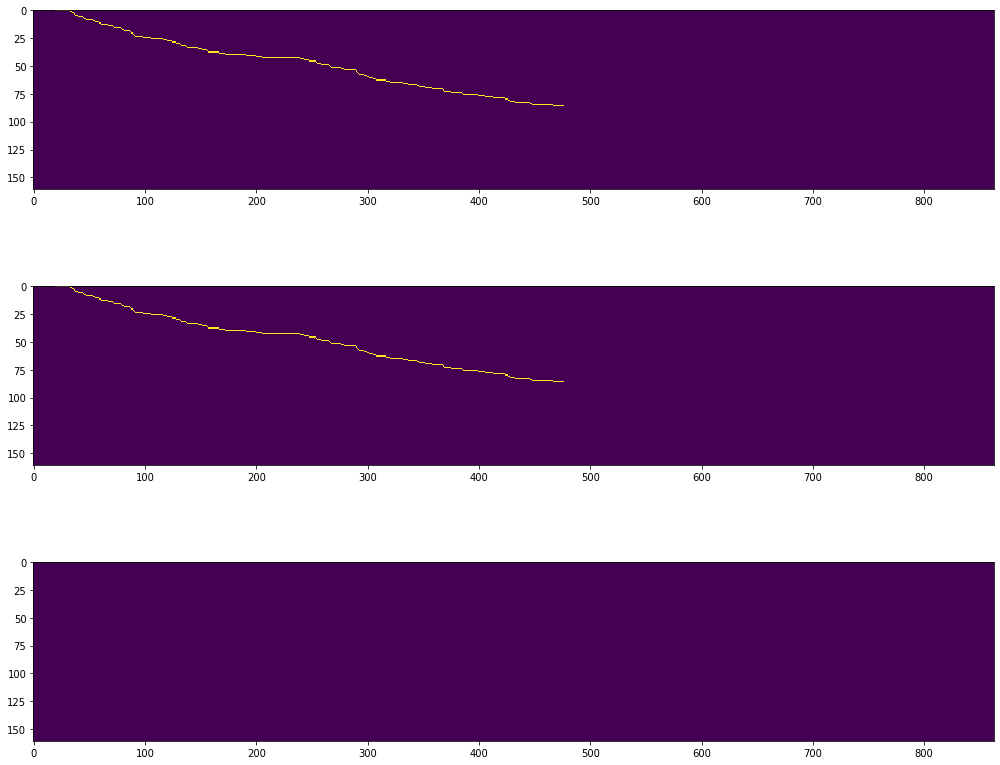

In [31]:
fig, axes = plt.subplots(3, 1, figsize=(14, 12))

axes[0].imshow(alignments_[0].cpu()[0, :, :])
axes[1].imshow(alignments[0].cpu()[0, :, :])
axes[2].imshow(alignments_[0].cpu()[0, :, :] - alignments[0].cpu()
               [0, :, :])
plt.tight_layout()          
plt.show()